In [1]:
%matplotlib widget
from tvb.simulator.plot.compare_integrators import CompareIntegrators

WARNING  File 'hemispheres' not found in ZIP.


# Comparing integration methods

Often it is difficult to know which is the best integration method for your simulation. TVB offers a handful of methods, with recently added variable order methods which allow one to safely choose higher time steps, as long as they remain smaller than the smallest time delay. In the following tutorial, we'll perform identical simulations, changing only the integration method in order to check what differences result.

In [2]:
ci = CompareIntegrators()
ci.methods

[(tvb.simulator.integrators.EulerDeterministic, 0.1),
 (tvb.simulator.integrators.HeunDeterministic, 0.2),
 (tvb.simulator.integrators.Dop853, 5.0),
 (tvb.simulator.integrators.Dopri5, 5.0),
 (tvb.simulator.integrators.RungeKutta4thOrderDeterministic, 0.4),
 (tvb.simulator.integrators.VODE, 5.0)]

Output()

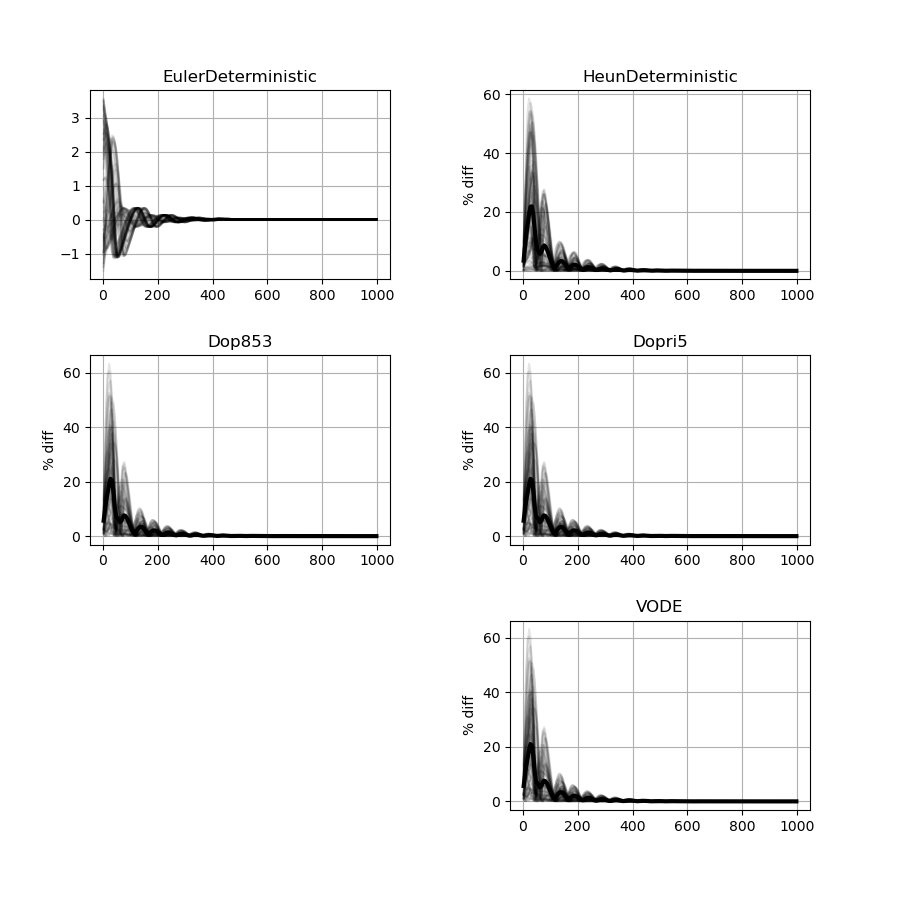

In [3]:
ci.show(comparison='Default')

At the moment of writing the RK4 method is not producing the correct number of output samples, and we're investigating the issue. In any case, the different integrators produce qualitatively similar results for this transient.

What is the order of magnitude of these diffences? This time, we compare pair-wise:

Output()

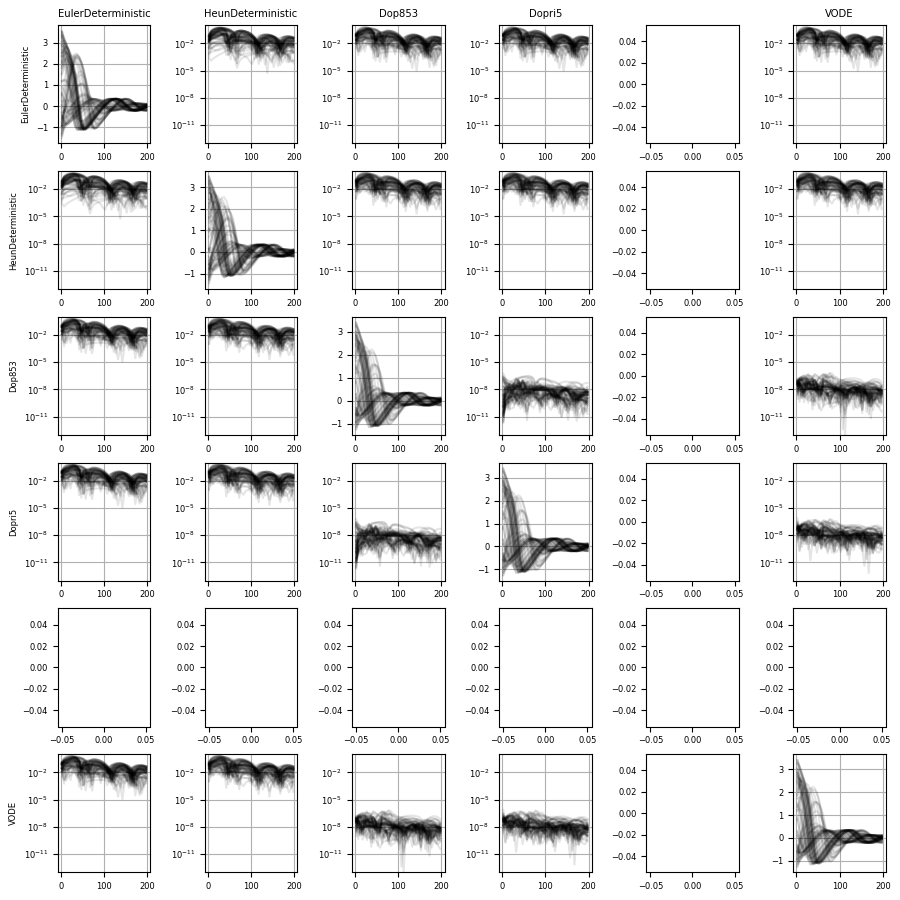

In [4]:
ci.show(comparison='Pairwise')

Along the diagonal, the time series of the simulation are plotted. Off the diagonal, the differences between methods for the same simulation are given. We can see that the Euler & Heun methods have low agreement with the variable order, which is to be expected, while the variable order methods are in good agreement. 

So far we've allowed the variable order integrators to choose their dt, bounded by a maximum of 5.0. We might ask, however, about the changes as dt grows. For example,

Output()

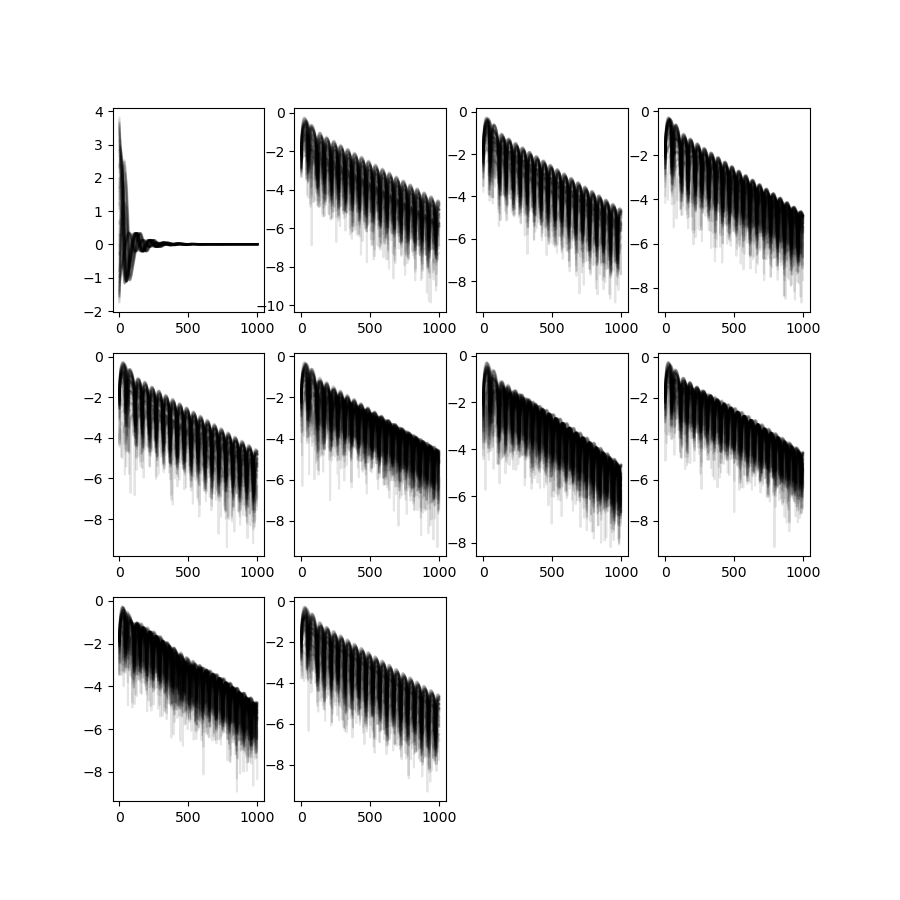

In [5]:
ci.show(comparison='dt Growth')

In conclusion, we can see that difference do exist between techniques. Variable order, especially the VODE, provide some speed up over fixed step, but because the connectivity depends on the step size, the step size should remain much lower that the smallest delays, to maintain a releastic simulation of the conduction speed.

When in doubt, compare the variable order solution to the fixed order, keeping in mind that a much lower step size will be required for the fixed step size, because such methods do not internally adapt their step size up or down according to an error criteria.